Cell 1: Markdown — Project Overview

# Fraud Detection Project - Task 1: Data Analysis and Preprocessing

This notebook covers:
- Loading and cleaning data from three CSV files.
- Handling missing values and duplicates.
- Exploratory Data Analysis (univariate and bivariate).
- Merging IP geolocation data.
- Feature engineering including time-based and transaction velocity features.
- Handling class imbalance with SMOTE.
- Data normalization, scaling, and encoding.

The goal is to prepare a clean, informative dataset ready for robust fraud detection modeling.


Cell 2: Imports

In [1]:
import sys
import os

# Add the project root directory to sys.path
sys.path.append(os.path.abspath(".."))


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils.data_utils import (
    load_data, handle_missing_values, clean_data, merge_ip_country,
    add_time_features, add_transaction_frequency, encode_categoricals,
    transform_and_balance
)
import datetime

sns.set(style='whitegrid')


Cell 3: Load Data

In [3]:
fraud_df, credit_df, ip_df = load_data()
print("Fraud Data shape:", fraud_df.shape)
print("Credit Card Data shape:", credit_df.shape)
print("IP Data shape:", ip_df.shape)


Fraud Data shape: (151112, 11)
Credit Card Data shape: (284807, 31)
IP Data shape: (138846, 3)


Cell 4: Markdown — Handling Missing Data

## Handling Missing Values

- For the `fraud_df`, missing ages are replaced by the median age to avoid bias from outliers.
- Missing categorical values (like `browser`) are replaced by the mode (most frequent).
- Remaining missing rows are dropped for simplicity.
- For other datasets, rows with missing data are dropped since missing info can harm integrity.


Cell 5: Handle Missing Values

In [4]:
fraud_df, credit_df, ip_df = handle_missing_values(fraud_df, credit_df, ip_df)


Cell 6: Markdown — Data Cleaning

## Data Cleaning

- Duplicate records can distort analysis and model training, so we remove them.
- Timestamps are converted to `datetime` types to enable time-based calculations.
- IP address bounds in `ip_df` are converted to numeric to enable comparisons.


Cell 7: Clean Data

In [5]:
fraud_df, credit_df, ip_df = clean_data(fraud_df, credit_df, ip_df)


Markdown — Exploratory Data Analysis (Univariate)

## Exploratory Data Analysis - Univariate

We explore distributions of key numerical features:
- User Age
- Purchase Value
- Transaction Amount (credit data)

Understanding these helps us identify data quality issues, outliers, and potential feature transformations.


Univariate Plots

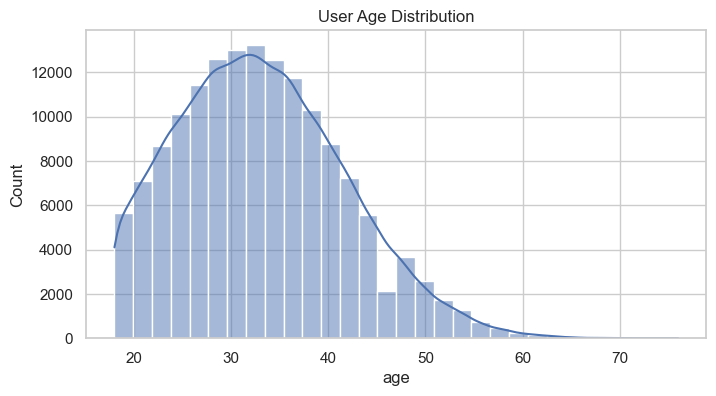

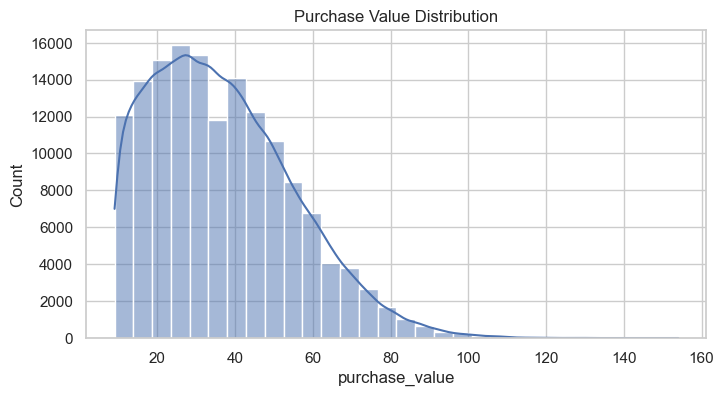

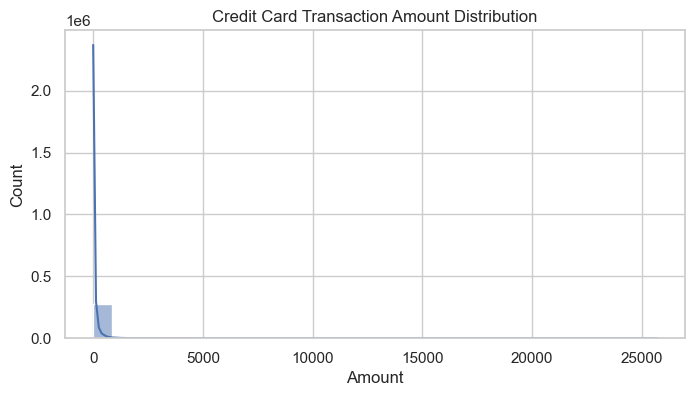

In [6]:
# Age distribution
plt.figure(figsize=(8,4))
sns.histplot(fraud_df['age'], bins=30, kde=True)
plt.title('User Age Distribution')
plt.show()

# Purchase Value distribution
plt.figure(figsize=(8,4))
sns.histplot(fraud_df['purchase_value'], bins=30, kde=True)
plt.title('Purchase Value Distribution')
plt.show()

# Credit card transaction amount distribution
plt.figure(figsize=(8,4))
sns.histplot(credit_df['Amount'], bins=30, kde=True)
plt.title('Credit Card Transaction Amount Distribution')
plt.show()


Exploratory Data Analysis (Bivariate)

## Exploratory Data Analysis - Bivariate

We compare feature distributions by fraud class to find patterns:
- Boxplots for numeric features against fraud class.
- Countplots for categorical features with fraud breakdown.
- Correlation heatmap of numeric features.


Bivariate Plots

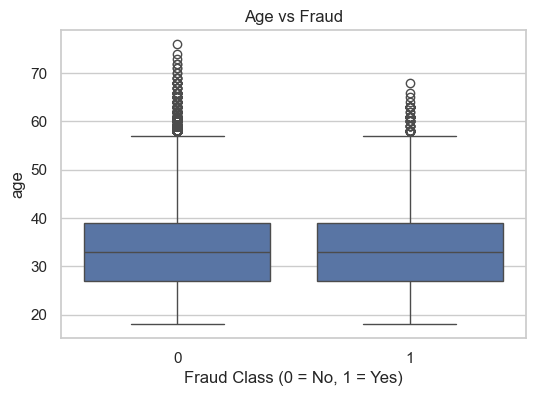

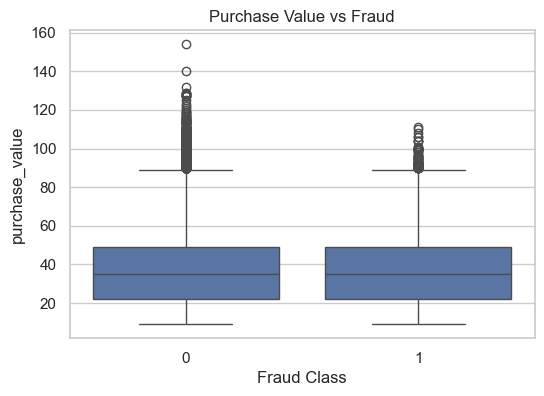

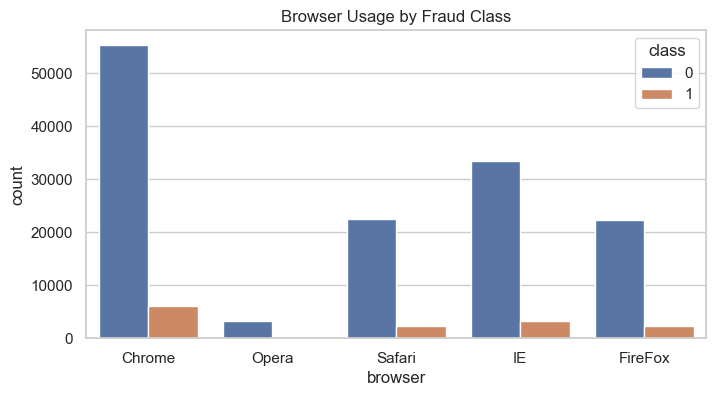

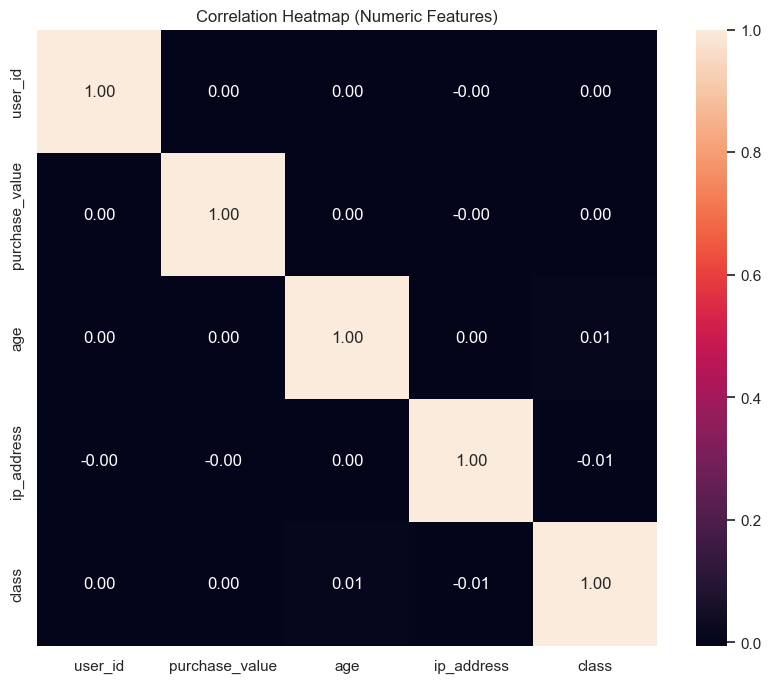

In [7]:
# Boxplot: Age vs Fraud
plt.figure(figsize=(6,4))
sns.boxplot(x='class', y='age', data=fraud_df)
plt.title('Age vs Fraud')
plt.xlabel('Fraud Class (0 = No, 1 = Yes)')
plt.show()

# Boxplot: Purchase Value vs Fraud
plt.figure(figsize=(6,4))
sns.boxplot(x='class', y='purchase_value', data=fraud_df)
plt.title('Purchase Value vs Fraud')
plt.xlabel('Fraud Class')
plt.show()

# Countplot: Browser vs Fraud
plt.figure(figsize=(8,4))
sns.countplot(x='browser', hue='class', data=fraud_df)
plt.title('Browser Usage by Fraud Class')
plt.show()

# Correlation heatmap for numeric columns in fraud_df
plt.figure(figsize=(10,8))
sns.heatmap(fraud_df.select_dtypes(include=np.number).corr(), annot=True, fmt=".2f")
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()


Cell 12: Merge IP with Country

In [8]:
fraud_df = merge_ip_country(fraud_df, ip_df)


c:\Users\Bob\Desktop\10Acadamy\week8&9\fraud-detection\utils\data_utils.py:77: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  fraud_df['ip_int'] = fraud_df['ip_int'].fillna(-1)


Cell 13: Feature Engineering (time features, frequency)


In [9]:
fraud_df = add_time_features(fraud_df)
fraud_df = add_transaction_frequency(fraud_df)


Cell 14: Markdown — Additional Features: Transaction Velocity

## Additional Feature Engineering: Transaction Velocity

We calculate the time since the last transaction for each user to capture transaction frequency dynamics.

Also, a rolling count of transactions in the last 24 hours per user is created.


Cell 15: Transaction Velocity Features

In [10]:
# Sort by user and purchase time
fraud_df = fraud_df.sort_values(['user_id', 'purchase_time'])

# Time since last transaction per user in hours
fraud_df['time_since_last_transaction'] = fraud_df.groupby('user_id')['purchase_time'].diff().dt.total_seconds() / 3600
fraud_df['time_since_last_transaction'] = fraud_df['time_since_last_transaction'].fillna(fraud_df['time_since_last_transaction'].median())

# Set purchase_time as index temporarily for rolling
fraud_df.set_index('purchase_time', inplace=True)

# Rolling transaction count in last 24 hours per user
fraud_df['rolling_24h_txn_count'] = fraud_df.groupby('user_id')['user_id'].rolling('24h').count().reset_index(level=0, drop=True)

# Reset index back to default
fraud_df.reset_index(inplace=True)


c:\Users\Bob\Desktop\10Acadamy\week8&9\fraud-detection\.fraud\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Cell 16: Encode categorical features

In [11]:
categorical_cols = ['browser', 'source', 'sex']
fraud_encoded = encode_categoricals(fraud_df, categorical_cols)


Cell 17: Prepare features and target

In [12]:
y = fraud_encoded['class']
X = fraud_encoded.drop(columns=['class'])


Cell 18: Balance, scale and split data

In [14]:
X_train, X_test, y_train, y_test = transform_and_balance(X, y)


🚨 Dropping columns with all NaNs: ['time_since_last_transaction']
✅ Final NaNs in X_train:
 Series([], dtype: int64)
✅ Shape before SMOTE: (105778, 20)


Cell 19: Markdown — Handling Class Imbalance
## Handling Class Imbalance

Fraud cases are much rarer than legitimate transactions.  
We use SMOTE to oversample the minority class (fraud) in training data only to avoid biasing the test set.

Data is scaled using StandardScaler to normalize feature ranges before modeling.


Cell 20: Final checks and visualization

X_train shape: (191744, 20)
X_test shape: (45334, 20)
y_train distribution:
 class
0    95872
1    95872
Name: count, dtype: int64


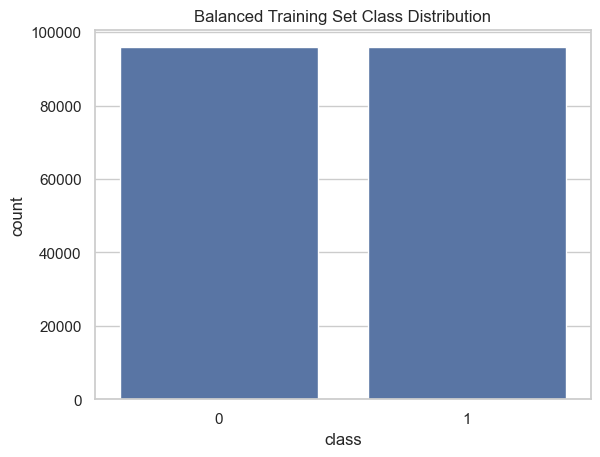

In [15]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train distribution:\n", pd.Series(y_train).value_counts())

sns.countplot(x=y_train)
plt.title("Balanced Training Set Class Distribution")
plt.show()
